# G2M Strategy - Regression Model Development 

**Prediction**

Given the results from our cleaned dataset, we have a good understanding of the data and the relationships that exist, and the insights gather will assist in determining the type of model in predicting future `profit`.

Analysis will consist of traditional hypothesis testing to more advanced modeling and techniques.


Time period of data is from **31/01/2016 to 31/12/2018**:


**Resources:**<br>
[G2M Strategy](https://blog.hubspot.com/sales/gtm-strategy)

In [227]:
# Import libraries 
import os
import sys
import pandas as pd
import numpy as np


# Matplotlib Visualizations
import shap
%matplotlib inline
import seaborn as sns
import matplotlib
import eli5
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from eli5.sklearn import PermutationImportance


# Plotly visualizations
import plotly
import plotly.express as px
from IPython.display import HTML
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


# Sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error


# Tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score
pd.set_option('display.max_columns',50)

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# Function to display plotly in jupyter notebook
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)
    
print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('Seaborn:',sns.__version__)
print('Plotly:',plotly.__version__)
print('TensorFlow:',tf.__version__)

Matplotlib: 3.1.1
Pandas: 1.1.3
Numpy: 1.23.0
Seaborn: 0.11.2
Plotly: 4.12.0
TensorFlow: 2.7.0


In [244]:
cab_data = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/cab_data_cleaned')
cab_yellow = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/yellow_cab.csv')
cab_pink = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/pink_cab.csv')

### Build on creating statistical analysis - answer business questions.

Perform analysis and provide visualizations to gather further insights and recommendations for the next steps in the process of determing optimal investment following the G2M strategy.

To achieve this we will apply machine learning techniques to predict future profit.

In [245]:
cab_data[['female', 'male']] = pd.get_dummies(cab_data["gender"])
cab_data[['yellow_cab', 'pink cab']] = pd.get_dummies(cab_data["company"])
cab_data[['card', 'cash']] = pd.get_dummies(cab_data["payment_mode"])
cab_data = cab_data.drop(['gender', 'company', 'payment_mode', 'customer_id'], axis=1)

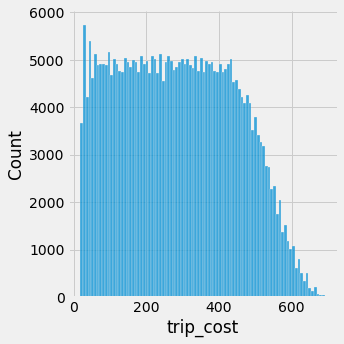

In [246]:
sns.displot(cab_data['trip_cost']);

## Model builing - Linear Regression

In [247]:
cab_data = cab_data.copy()

In [248]:
# Split data into train, val, and test
train = cab_data.iloc[:int(len(cab_data) * 0.8)]
val = cab_data.iloc[int(len(cab_data) * 0.8):int(len(cab_data) * 0.9)]
test = cab_data.iloc[int(len(cab_data) * 0.9):]

In [249]:
# Split our data into and validation
target = 'trip_cost'
features = cab_data.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [250]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.9808236664031919


In [251]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

travel_date           0.006698
transact_id           0.000002
city                 -0.029307
km_travelled         12.383227
price_charged         0.005678
age                   0.003337
monthly_income       -0.000006
price_inc_05          0.005962
price_diff            0.000284
new_price_charged     0.005962
travel_date.1         0.006698
female                0.108116
male                 -0.108116
yellow_cab          -23.511349
pink cab             23.511349
card                  0.005786
cash                 -0.005786
dtype: float64

## Random Forest

In [252]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=40, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.9863130751391601


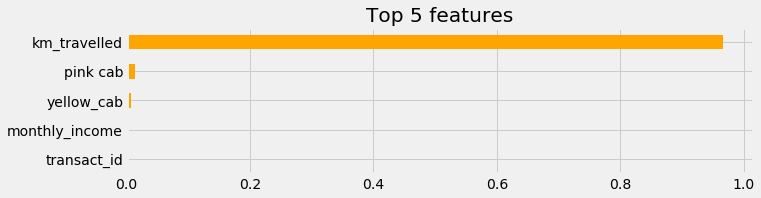

In [253]:
# Plot feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)


n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='orange');

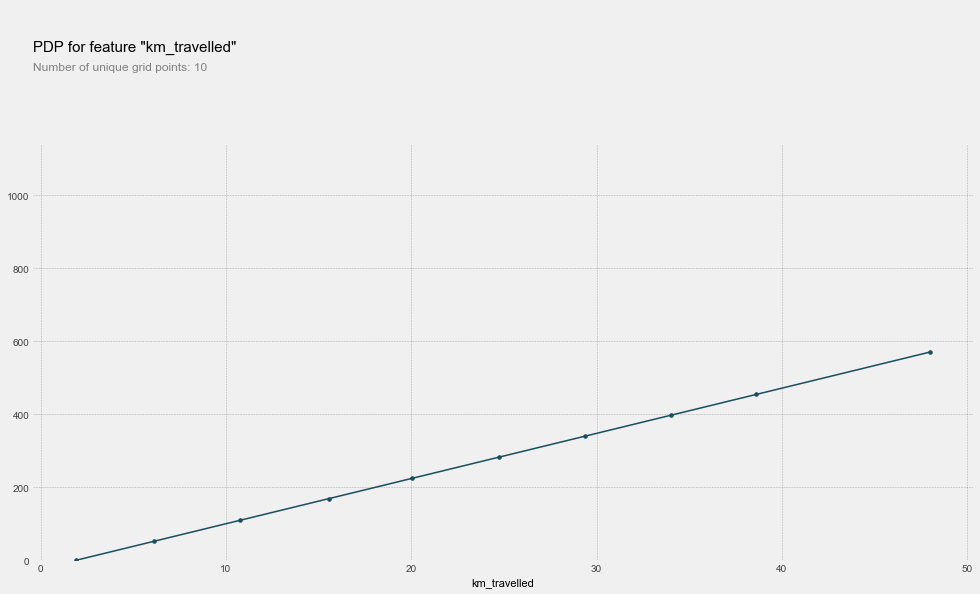

In [254]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'km_travelled'

isolated = pdp_isolate(
    model =  lr, 
    dataset = X_val, 
    model_features = X_val.columns, 
    feature= feature
)

pdp_plot(isolated, feature);

(0, 50)

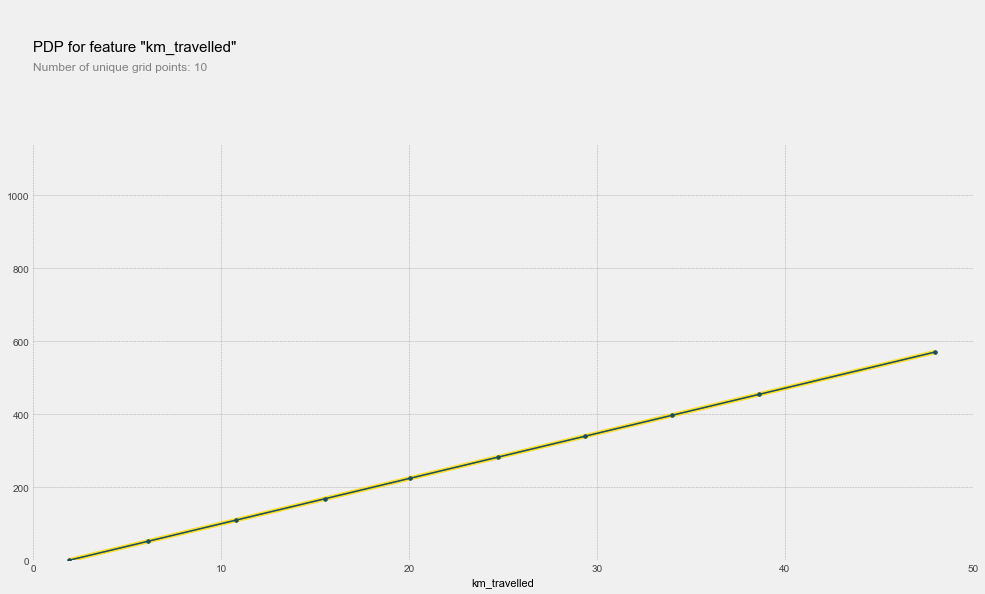

In [255]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01);
plt.xlim([0, 50])

In [256]:
# Random forest predictions
predictions = pipeline.predict(X_val)
y_val = y_val.values.tolist()
actual = y_val
predictions = pd.DataFrame(predictions, columns=['predicted'])
actual = pd.DataFrame(actual, columns=['actual'])
predictions['actual'] = actual['actual']
predictions.head()

,predicted,actual
0,439.059060,463.9536
1,147.513125,154.5840
2,547.445760,520.7904
3,261.623910,246.5820
4,144.005820,133.4160


In [257]:
# Linear regression predictions
predictions = lr.predict(X_val)
actual = y_val
predictions = pd.DataFrame(predictions, columns=['predicted'])
actual = pd.DataFrame(actual, columns=['actual'])
predictions['actual'] = actual['actual']
predictions.head()

,predicted,actual
0,433.188326,463.9536
1,135.459823,154.5840
2,527.539434,520.7904
3,263.225685,246.5820
4,149.767650,133.4160


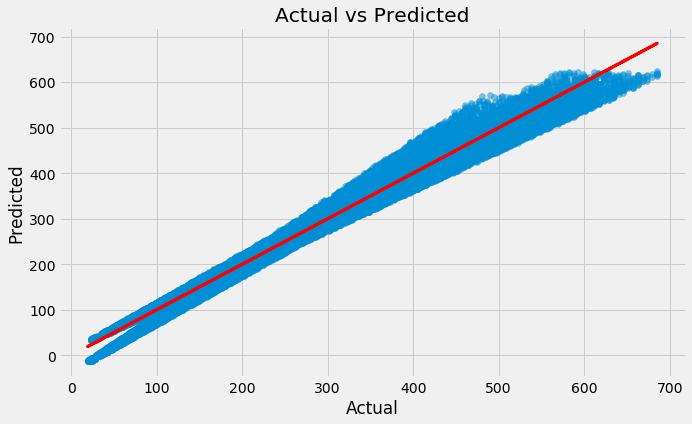

In [258]:
# Plot actual vs predicted using annotaions, scatter plot, and regression line 
plt.figure(figsize=(10,6))
plt.scatter(predictions['actual'], predictions['predicted'], alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot(predictions['actual'], predictions['actual'], color='red', linewidth=3)
plt.show()

#### Cab Investment – G2M Strategy
***

**Conclusion**

- Number of **transactions** are seasonal, peaking around the first of the year for several periods. This would likely be due to colder weather reducing walking and increasing car issues.
- Average age of customer is `35` with standard deviation of `12`, so our **target audience** would be between `23-47`.
- Average Price Charged `$424.20`
- Average **KM Travelled** `22.6`
- Average **Trip Cost** `$286.2`
- There are `3.1` times as many transactions at **Yellow Cab** than **Pink Cab**
- The **cost of a trip** has a strong `high correlation` with km travelled
- **Price charged** is also `highly correlated` to km travelled and cost of trip
- **Profits** are `highest` in Nashville, Chicago, Silicon Valley, Dallas, with Los Angeles and Tucson being close for tying 5th.


**Recommendations**

In implementing our Go-to-market strategy the Data Science team recommends that financial investment would have a profitable ROI, from preliminary analysis. 

Further analysis using machine learning techniques, would be required to determine if the investment would be profitable over time such as time series prediction and some form of regression analysis.